## Helpful Python Libraries

In [63]:
import pandas as pd
import numpy as np
import csv
import matplotlib as mp
import matplotlib.pyplot as plt
from numpy.lib import recfunctions
import datetime
import numpy.lib.recfunctions as recfn
import boto3
import sys
from IPython.display import clear_output
from scipy import stats, fftpack
from scipy.stats import kurtosis, skew, iqr, t
import pickle
from scipy import io as sio
s3 = boto3.resource('s3')
from io import BytesIO

## Constants

In [99]:
FLGHTLEN = .75 # Filter out anything that is less than this flight time
IN_BKT = 'iia-vault-telemetry-practice-unzipped'
SMPL_SIZES= [.01,.01,.1,.1]
RANDSEED= 42 # Urban Data Science Myth- Apparently gives best results!!
# NUMOFVARS= 30 # Number of variables from the mat files to be selected
PRINTATEVERY= 2500 # Key Values

## Variables

In [3]:
continuous = ['BLAC','CTAC','WS','ALTR']
degs = ['AOA1','AOA2','PTCH','ROLL']

## Bucket Read

In [4]:
def s3_bucket_object_keys(bucket_name= IN_BKT):
    bucket = s3.Bucket(bucket_name)
    key_list=[]
    for key in bucket.objects.all():
        key_list.append(key)
    sorted(key_list, key = lambda x: int(x.key[16:28]))
    return(key_list)

In [5]:
key_list = s3_bucket_object_keys()

## Sample Prep

In [6]:
def pick_random_sets(mat_list, pct_size=SMPL_SIZES):
    np.random.seed(seed=RANDSEED)
    smpl_sets=[]
    for pct in pct_size:
        sz = int(pct*len(mat_list))
        smpl_sets.append(np.random.choice(mat_list, size=sz, replace=False))
    return(smpl_sets)

In [105]:
samples= pick_random_sets(key_list)

In [8]:
def load_mat_file(s3_key, bucketname= IN_BKT):
    s3 = boto3.resource('s3')
    obj = s3.Object(bucketname, s3_key.key)
    inMATFile = obj.get()['Body'].read()
    raw_mat = sio.loadmat(BytesIO(inMATFile))
    return(raw_mat)

## Flight Length 

In [9]:
def flight_len(mat):
    return(round(len(mat['SAT']['data'][0][0])/3600,2))

In [10]:
def flght_start_end(mat):
    lat = mat['LATP']['data'][0][0]
    long = mat['LONP']['data'][0][0]
    return(lat[5][0],long[5][0], lat[-5][0],long[-5][0])

In [11]:
# flght_details =[]
# for key in key_list:
#     mat = load_mat_file(key)
#     flg_len = flight_len(mat)
#     if flg_len >= .5:
#         start_lat,start_long, end_lat,end_long= flght_start_end(mat)
#         flght_details.append([key.key, flg_len,start_lat,start_long, end_lat,end_long])

In [12]:
# flt= pd.DataFrame(flght_details)

In [13]:
# flt.to_csv('flight_time_destination.csv')

# Flight Time & Destination Analysis

In [15]:
flt = pd.read_csv('flight_time_destination.csv', header=0,index_col= 1)

In [16]:
flt.head()

,Unnamed: 0,1,2,3,4,5
0,,,,,,
Flight 652/1/652200101092009.mat,0,0.55,0.000000,0.351562,0.000000,0.351562
Flight 652/1/652200101120916.mat,1,1.03,37.241767,-93.385319,0.000000,0.351562
Flight 652/1/652200101121118.mat,2,1.47,35.045186,-89.978885,0.000000,0.351562
Flight 652/1/652200101121218.mat,3,1.48,39.046442,-84.660818,0.000000,0.351562
Flight 652/1/652200101121341.mat,4,1.42,39.290887,-94.711075,35.041238,-89.981979


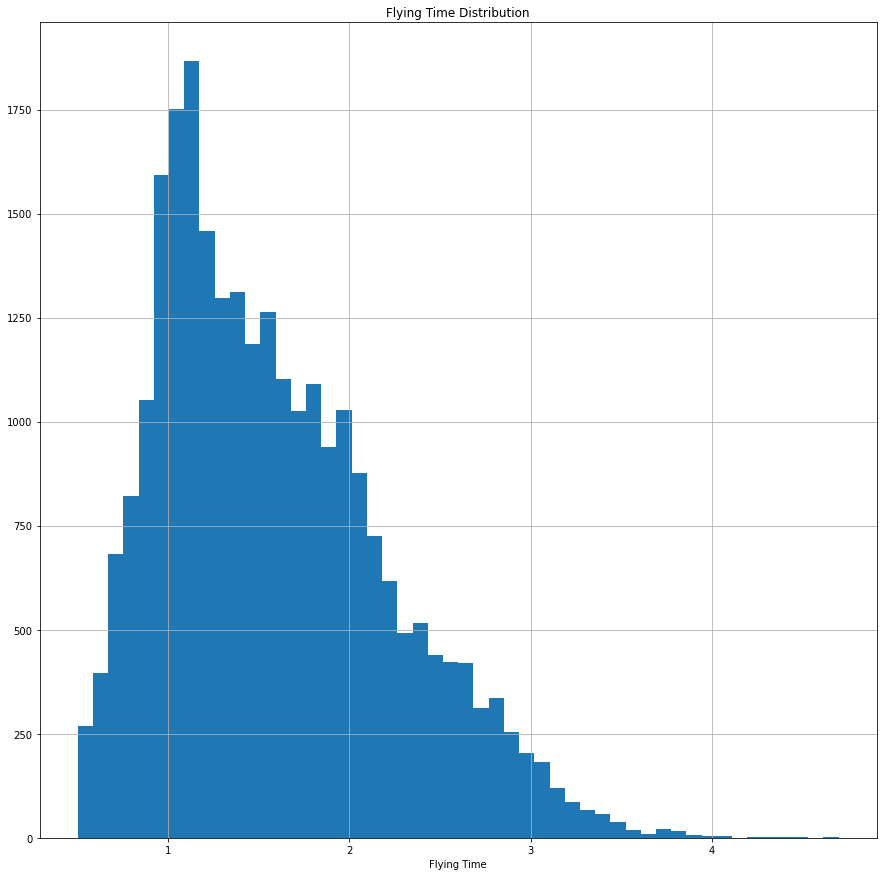

In [17]:
flt.loc[:,'1'].hist(figsize=(15,15), bins=50)
plt.title('Flying Time Distribution')
plt.xlabel('Flying Time')
plt.show()

In [18]:
dest_pair= flt.loc[:,'1':'5'].apply(lambda x: round(x,2))

In [19]:
dest_pair_cnts= dest_pair.groupby(['2','3','4','5'], as_index = False).count().sort_values('1', ascending= False)

In [20]:
dest_pair_cnts['1']= 100*dest_pair_cnts['1']/dest_pair_cnts['1'].sum()

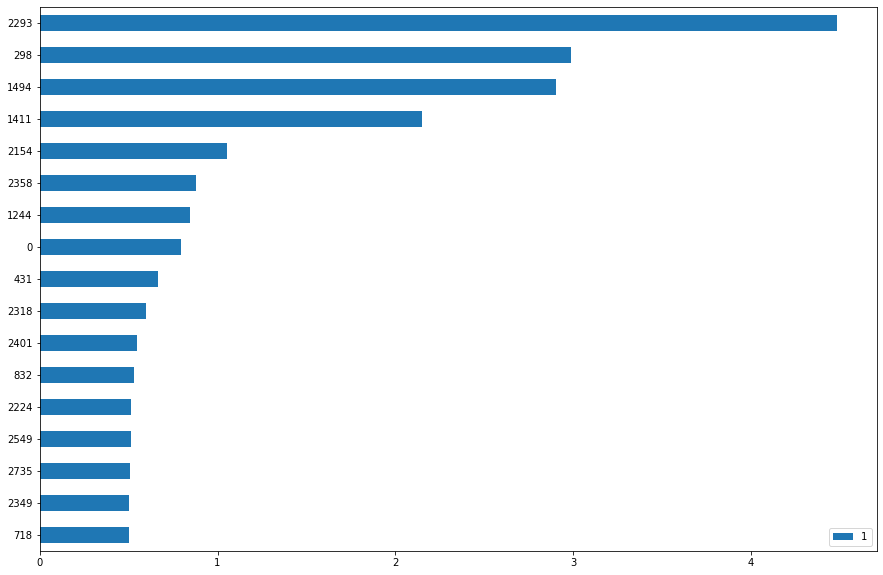

In [21]:
ax= dest_pair_cnts.loc[dest_pair_cnts['1']> .5].plot(y='1', kind= 'barh', figsize=(15,10))
ax.invert_yaxis()

In [14]:
def flght_filter(mat, flight_length= FLGHTLEN):
    t_len= len(mat['LGDN']['data'][0][0])/3600
    valid_lnd= len(np.unique(mat['LGDN']['data'][0][0], return_counts=False))
    if t_len >= flight_length and valid_lnd >= 2:
        return(True)
    else:
        return(False)

In [15]:
def steady_flight(mat):
    lndg= mat['LGUP']['data'][0][0]
    lndg_flg_chg= []
    for i in range(len(lndg)-1):
        if (lndg[i]!=lndg[i+1]):
            lndg_flg_chg.append(i+1)
    return(lndg_flg_chg)

# GESD

In [16]:
from scipy.stats import kurtosis, skew, iqr, t
def grubbs_stat(y):
    std_dev = np.std(y)
    avg_y = np.mean(y)
    abs_val_minus_avg = abs(y - avg_y)
    max_of_deviations = max(abs_val_minus_avg)
    max_ind = np.argmax(abs_val_minus_avg)
    Gcal = max_of_deviations/ std_dev
#     print("Grubbs Statistics Value : {}".format(Gcal))
    return(Gcal, max_ind)

In [17]:
from scipy.stats import kurtosis, skew, iqr, t
def calculate_critical_value(size, alpha):
    t_dist = t.ppf(1 - alpha / (2 * size), size - 2)
    numerator = (size - 1) * np.sqrt(np.square(t_dist))
    denominator = np.sqrt(size) * np.sqrt(size - 2 + np.square(t_dist))
    critical_value = numerator / denominator
#     print("Grubbs Critical Value: {}".format(critical_value))
    return(critical_value)

In [18]:
from scipy.stats import kurtosis, skew, iqr, t
def check_G_values(Gs, Gc, inp, max_index, eco= False):
    if eco == True:
        if Gs > Gc:
            print('{} is an outlier. G > G-critical: {:.4f} > {:.4f} \n'.format(inp[max_index], Gs, Gc))
        else:
            print('{} is not an outlier. G > G-critical: {:.4f} < {:.4f} \n'.format(inp[max_index], Gs, Gc))

In [19]:
from scipy.stats import kurtosis, skew, iqr, t
def ESD_Test(input_series, alpha, max_outliers):
    for iterations in range(max_outliers):
        Gcritical = calculate_critical_value(len(input_series), alpha)
        Gstat, max_index = grubbs_stat(input_series)
        check_G_values(Gstat, Gcritical, input_series, max_index)
        input_series = np.delete(input_series, max_index)
        return([Gcritical, Gstat, max_index])

## STL- Parked as of now 

In [20]:
from statsmodels.tsa.seasonal import STL


In [21]:
def calc_stl_para(data):
    stl_prep = pd.Series(np.squeeze(data), index=pd.date_range('1-1-2001', periods=len(data), freq='D'), name = 'var')
    stl = STL(stl_prep, seasonal=3)
    res = stl.fit()
    fig = res.plot()
    return(res)

In [22]:
# stl_prep = pd.Series(np.squeeze(data), index=pd.date_range('1-1-2001', periods=len(data), freq='S'), name = 'var')

NameError: name 'data' is not defined

In [109]:
# from statsmodels.tsa.forecasting.stl.STLForecast import STLForecast
# from statsmodels.tsa.arima.model import ARIMA

# stl_prep.index.freq = stl_prep.index.inferred_freq
# stlf = STLForecast(elec_equip, ARIMA, model_kwargs=dict(order=(1,1,0), trend="c"))
# stlf_res = stlf.fit()

# forecast = stlf_res.forecast(24)
# plt.plot(elec_equip)
# plt.plot(forecast)
# plt.show()

## Computing statistical measure for Continuous features

In [70]:
from scipy.stats import kurtosis, skew, iqr, t
def conti_stats(mat, continuous, lngd_idx):
    var_stats={}
    for v in continuous:
#         var_stats['key']= v
        stats= {}
        data =  mat[v]['data'][0][0]
        rate = mat[v]['Rate'][0][0][0][0]
        data = np.array(data[0: int(lngd_idx[0]*rate): rate])
        stats['mean']= np.mean(data)
        stats['uniques']= len(np.unique(data))
        stats['variance']= np.var(data)
        stats['kurt']= kurtosis(data)[0]
        stats['skew']= skew(data)[0]
        stats['iqr']=iqr(data)
        try:
            stats['GESD']= ESD_Test(np.squeeze(data).T,0.05,5)
        except: 
            stats['GESD']= [np.NaN, np.NaN, np.NaN]
        var_stats[v]= stats
    return(var_stats)

## Degrees Features

In [71]:
def fromdeg(d):
    r = d * np.pi / 180.
    return(np.cos(r), np.sin(r))

In [72]:
def deg_stats(mat, degs, lngd_idx):
    var_stats= {}
    for d in degs:
        data =  mat[d]['data'][0][0]
        rate = mat[d]['Rate'][0][0][0][0]
        data = np.array(data[0: int(lngd_idx[0]*rate): rate])
        [c,s]= fromdeg(data)
        for i, data in enumerate([c,s]):
            if i == 0:
                var_name = d+'_'+'cos'
            else:
                var_name = d+'_'+'sin'
            stats={}
            stats['mean']= np.mean(data)
            stats['uniques']= len(np.unique(data))
            stats['variance']= np.var(data)
            stats['kurt']= kurtosis(data)[0]
            stats['skew']= skew(data)[0]
            stats['iqr']=iqr(data)
            try:
                stats['GESD']= ESD_Test(np.squeeze(data).T,0.05,5)
            except: 
                stats['GESD']= [np.NaN, np.NaN, np.NaN]
            var_stats[var_name]= stats
    return(var_stats) 

In [155]:
var_stats = deg_stats(mat, degs)

## Main

In [112]:
def create_dict():
    flghts =0
    start = datetime.datetime.now()
    print('Main start:', datetime.datetime.now())
    mat_list = s3_bucket_object_keys()
    print('Key List Read:', datetime.datetime.now())
    smpl_set= pick_random_sets(mat_list)
    print('Key List Split:', datetime.datetime.now())
    s3_keys= samples[1]
    takeoff_stats= {}
    for ind, key in enumerate(s3_keys):
        flght_detail= key.key[:28]
        train = load_mat_file(key)
        stats={}
        if flght_filter(train)== True:
            take_off_idx= steady_flight(train)
#             var_list= select_variables(train, [0,take_off_idx[0]])
            flghts +=1
            try:
                stats['conti']= conti_stats(train, continuous, take_off_idx)
                stats['degs']= deg_stats(train, degs, take_off_idx)
            except:
                continue
            takeoff_stats[flght_detail]= stats
            if ind% PRINTATEVERY == 0:
                print('Processing Key:', key.key, datetime.datetime.now())
#                 print(flght_detail, stats)
    end = datetime.datetime.now()
    print("Time Taken to run the function ",str(end-start))
    print("Total Flights that meet criteria:", flghts)
    return(takeoff_stats)

In [113]:
takeoff_stats= create_dict()

Main start: 2020-08-30 17:18:57.850419
Key List Read: 2020-08-30 17:19:19.623159
Key List Split: 2020-08-30 17:19:20.088628
Processing Key: Flight 661/6/661200210031520.mat 2020-08-30 17:19:20.524725


<ipython-input-16-fd0cb43dfec9>:8: RuntimeWarning: invalid value encountered in double_scalars
  Gcal = max_of_deviations/ std_dev


Time Taken to run the function  0:03:03.214626
Total Flights that meet criteria: 564


In [114]:
file_to_write = open("flight_stats_prt1_1pct.pickle", "wb")
pickle.dump(takeoff_stats, file_to_write)

In [52]:
mat_list = s3_bucket_object_keys()
key = mat_list[-1]
flght_detail= key.key[:28]
train = load_mat_file(key)
take_cmplt_idx= steady_flight(train)[0]

In [95]:
with open('flight_stats_572.pickle', 'rb') as f:
    x = pickle.load(f)

In [96]:
x

{'Flight 659/3/659200201270513': {'conti': {'BLAC': {'mean': 0.03164351061551706,
    'uniques': 102,
    'variance': 0.004574987648848767,
    'kurt': 6.11652345009953,
    'skew': 2.781395118868852,
    'iqr': 0.007815999910235405,
    'GESD': [3.8641834950019187, 3.923266912814114, 485]},
   'CTAC': {'mean': 0.00017126796999089898,
    'uniques': 37,
    'variance': 3.307490497985695e-05,
    'kurt': 32.19982064586517,
    'skew': 1.9307904103208224,
    'iqr': 0.0,
    'GESD': [3.8641834950019187, 9.823327758650768, 490]},
   'WS': {'mean': 0.3988344431873337,
    'uniques': 15,
    'variance': 4.341422600883697,
    'kurt': 52.519257923960595,
    'skew': 6.8824483788650745,
    'iqr': 0.0,
    'GESD': [3.8641834950019187, 9.847888524278725, 501]},
   'ALTR': {'mean': 71.2988047808765,
    'uniques': 44,
    'variance': 237713.10195076262,
    'kurt': 33.39063530471801,
    'skew': 5.772975364971274,
    'iqr': 80.0,
    'GESD': [3.8641834950019187, 7.500028506686578, 500]}},
  'd

In [102]:
len(takeoff_stats.keys())

572